<a href="https://colab.research.google.com/github/euxoa/ompeluseura/blob/master/Ompeluseura_apt_get.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
start_time <- Sys.time()

In [0]:
# install.packages takes ages (20mins) in Colab so we will install dependencies apt-get
system("apt-get update")
system("apt install -y r-cran-readr")
system("apt install -y r-cran-dplyr")
system("apt install -y r-cran-rstan")
print(Sys.time() - start_time)

Time difference of 10.17982 secs


In [0]:
options(repr.plot.width  = 6,
        repr.plot.height = 4)
Sys.setenv(USE_CXX14 = 1)
library("rstan") # observe startup messages


In [0]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [0]:
library("dplyr")
library("ggplot2")

In [0]:
print(Sys.time() - start_time)

Time difference of 5.484179 mins


In [0]:
d <- readr::read_csv("https://raw.githubusercontent.com/euxoa/ompeluseura/master/kilpisjarvi_raw.csv") %>% 
  setNames(c("year", "month", "day", "_clock", "tzone", "temp")) %>%
  mutate(t = ISOdate(year, month, day), 
         f_month = as.factor(month),
         decade = as.numeric(t - ISOdate(2000, 1, 1), units="days")/365.25) %>%
  select(year, f_month, t, decade, temp)


Parsed with column specification:
cols(
  Vuosi = col_double(),
  Kk = col_double(),
  Pv = col_double(),
  Klo = col_time(format = ""),
  Aikavyöhyke = col_character(),
  `Kuukauden keskilämpötila (degC)` = col_double()
)


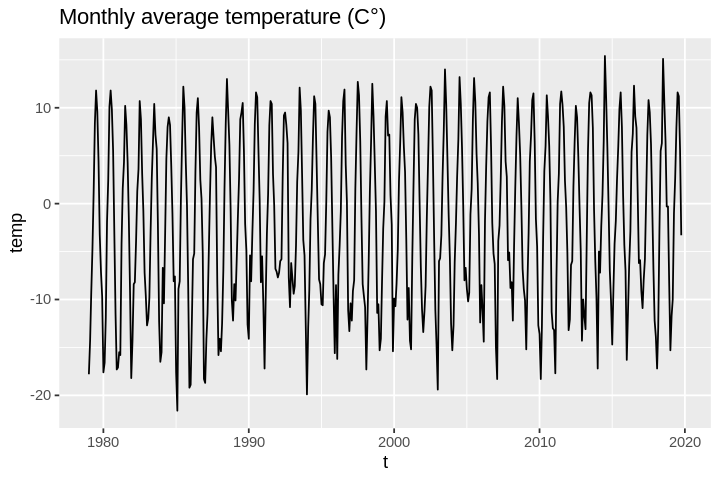

In [0]:

ggplot(d, aes(x=t, y=temp)) + geom_line() + labs(title = "Monthly average temperature (C°)")

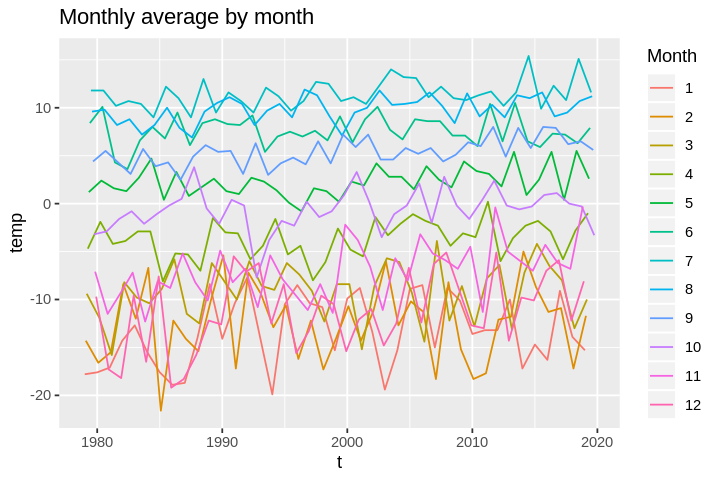

In [0]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_line() + labs(title = "Monthly average by month", color= "Month"


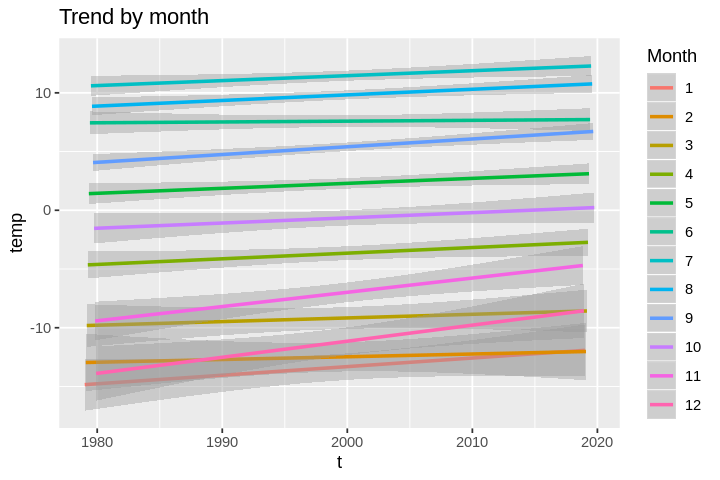

In [0]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_smooth(method="lm") + labs(title = "Trend by month", color= "Month")

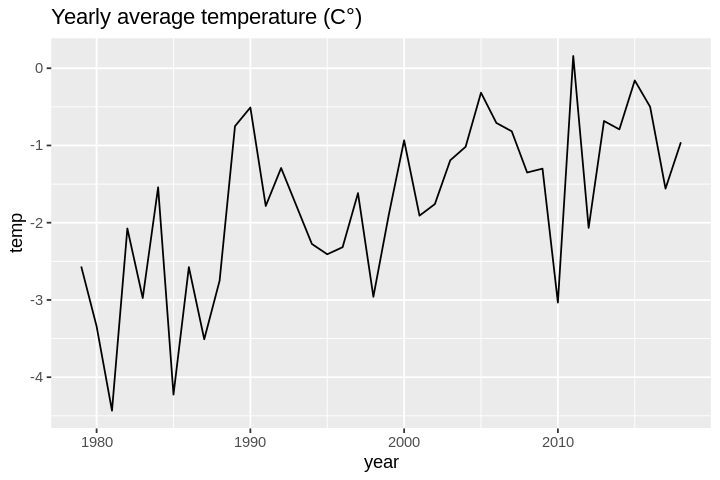

In [0]:
d_year <- d %>% group_by(year) %>% summarise(n=n(), temp=mean(temp), decade=mean(decade)) %>% filter(n==12)

ggplot(d_year, aes(x=year, y=temp)) + geom_line() + labs(title = "Yearly average temperature (C°)")

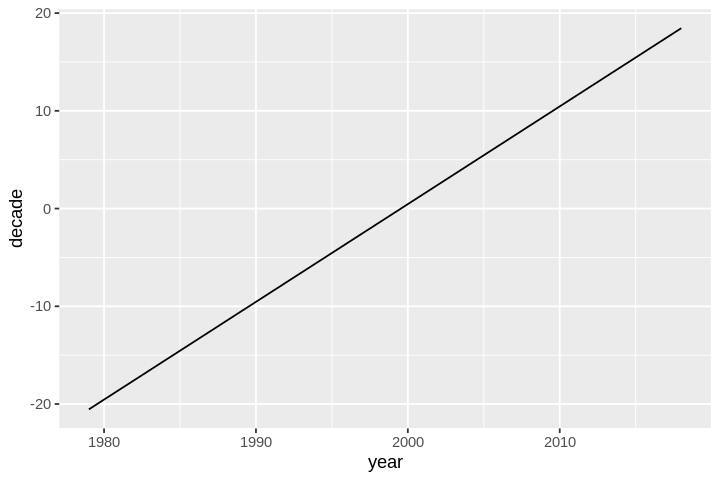

In [0]:
ggplot(d_year, aes(x=year, y=decade)) + geom_line()

In [0]:
stan_data <- with(d_year, list(N=length(temp), decade=decade, temp=temp))

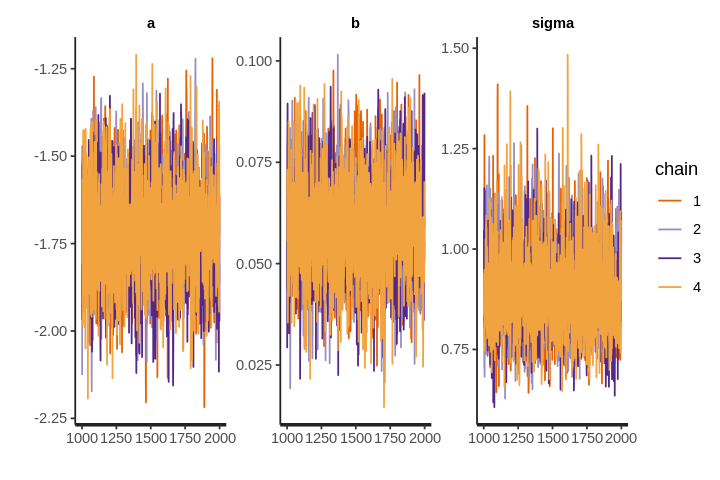

In [0]:
model_simple_normal <- "
data {
  int<lower=0> N;
  vector[N] decade;
  vector[N] temp;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  temp ~ normal(a + b * decade, sigma);
}
"
m_sn <- stan_model(model_code = model_simple_normal) # compilation takes time if model is changed
fit_sn <- sampling(m_sn, data = stan_data)
traceplot(fit_sn)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


Inference for Stan model: 1ba1786ebbac82d7206777eaaf7e168e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
a      -1.71    0.00 0.14  -1.99  -1.81  -1.71  -1.62  -1.42  3281    1
b       0.06    0.00 0.01   0.04   0.05   0.06   0.07   0.08  3907    1
sigma   0.89    0.00 0.11   0.71   0.82   0.88   0.96   1.14  3490    1
lp__  -14.49    0.03 1.24 -17.59 -15.03 -14.18 -13.58 -13.05  1978    1

Samples were drawn using NUTS(diag_e) at Wed Dec  4 08:09:32 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

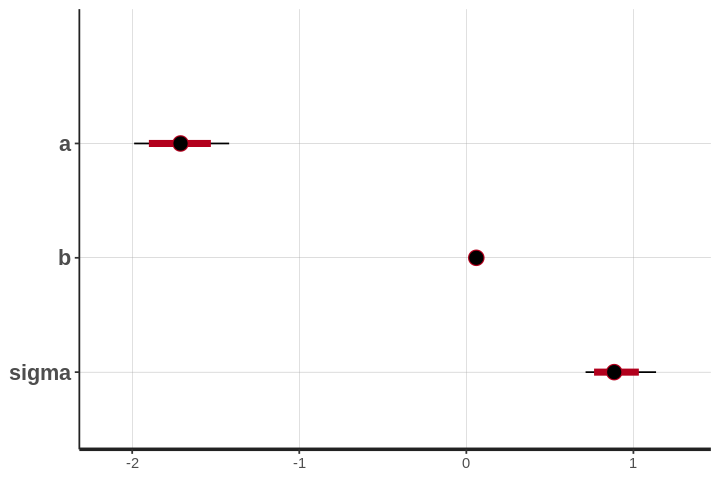

In [0]:
plot(fit_sn)
fit_sn

In [0]:
model_str1 <- "
data {
  int N;
  real decade[N];
  real temp[N];
}
parameters {
  real<lower=0> sigma;
  real b;
  real k;
}
model {
  for (i in 1:N) temp[i] ~ normal(k*decade[i] + b, sigma);
}
"
m <- stan_model(model_code = model_str1) # compilation takes time if model is changed
fit <- sampling(m, data = stan_data)
traceplot(fit)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


Inference for Stan model: 773a09c56fea6ea29a029fd5b0b2b1d0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
sigma   0.90    0.00 0.11   0.70   0.82   0.89   0.96   1.14  3296    1
b      -1.70    0.00 0.14  -1.98  -1.80  -1.71  -1.61  -1.42  3731    1
k       0.06    0.00 0.01   0.03   0.05   0.06   0.07   0.08  3604    1
lp__  -14.54    0.03 1.31 -18.06 -15.11 -14.19 -13.60 -13.06  1760    1

Samples were drawn using NUTS(diag_e) at Wed Dec  4 07:59:41 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

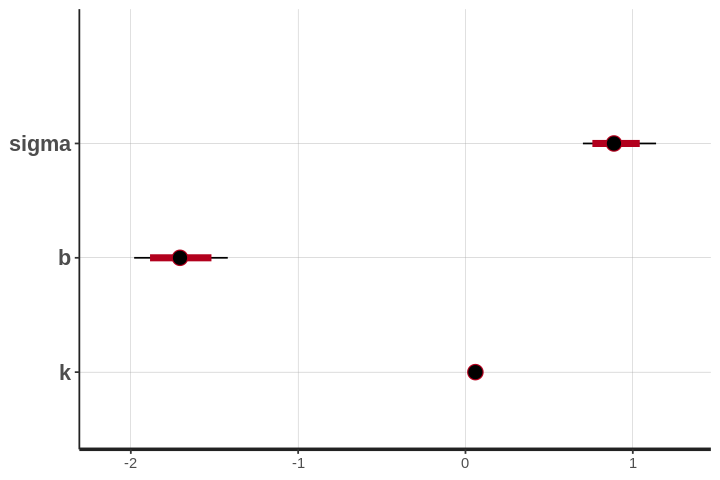

In [0]:
plot(fit)
fit


ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


Inference for Stan model: 773a09c56fea6ea29a029fd5b0b2b1d0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
sigma   0.90    0.00 0.11   0.72   0.82   0.88   0.96   1.16  2563    1
b      -1.71    0.00 0.15  -2.01  -1.81  -1.71  -1.61  -1.42  3393    1
k       0.06    0.00 0.01   0.03   0.05   0.06   0.07   0.09  4005    1
lp__  -14.59    0.03 1.36 -18.11 -15.16 -14.24 -13.61 -13.07  1555    1

Samples were drawn using NUTS(diag_e) at Wed Dec  4 07:46:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

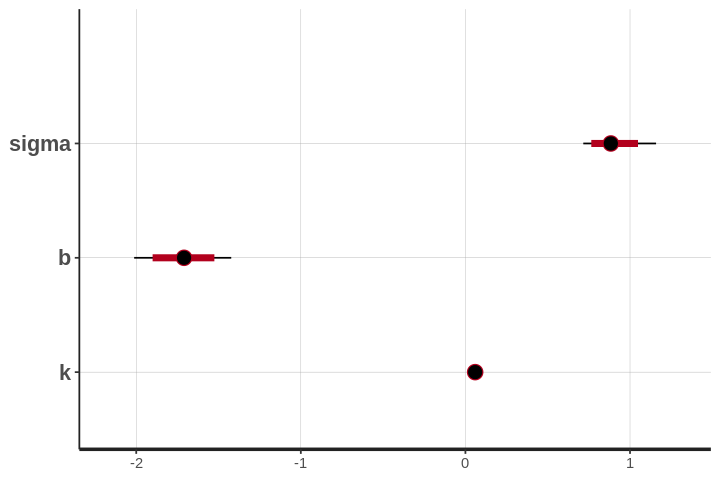